# Find published articles missing from bioRxiv

In [1]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
from scipy.spatial.distance import cdist
import scipy.stats
import seaborn as sns
from sklearn.metrics import roc_curve, auc, recall_score, precision_score
import tqdm

import svgutils.transform as sg
from svgutils.compose import Unit
from cairosvg import svg2png
from IPython.display import Image
from lxml import etree

# Load Embeddings

## bioRxiv

In [2]:
biorxiv_journal_df = (
    pd.read_csv(
        "../journal_tracker/output/mapped_published_doi_before_update.tsv", sep="\t"
    )
    .rename(index=str, columns={"doi": "preprint_doi"})
    .groupby("preprint_doi")
    .agg(
        {
            "document": "last",
            "category": "first",
            "preprint_doi": "last",
            "published_doi": "first",
            "pmcid": "first",
            "pmcoa": "first",
        }
    )
    .reset_index(drop=True)
)
biorxiv_journal_df.head()

,document,category,preprint_doi,published_doi,pmcid,pmcoa
0,000026_v1.xml,genetics,10.1101/000026,10.1371/journal.pgen.1004412,PMC4125079,True
1,000042_v2.xml,genomics,10.1101/000042,10.1038/nrg3723,PMC4151119,False
2,000067_v1.xml,genomics,10.1101/000067,10.1038/nature12904,PMC4285441,True
3,000091_v1.xml,synthetic biology,10.1101/000091,NaN,NaN,False
4,000109_v1.xml,evolutionary biology,10.1101/000109,10.1371/journal.pgen.1004410,PMC4072524,True


In [3]:
biorxiv_embed_df = pd.read_csv(
    Path("../word_vector_experiment/output/")
    / "word2vec_output/"
    / "biorxiv_all_articles_300.tsv.xz",
    sep="\t",
)
biorxiv_embed_df = biorxiv_embed_df.dropna()
biorxiv_embed_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,0.063813,0.012187,-0.156229,-0.158987,0.165480,-0.346612,0.001741,-0.107139,0.684055,...,-0.140772,-0.143405,-0.081427,-0.248220,-0.771470,-0.235455,0.547801,0.859663,-0.063151,0.012667
1,775270_v1.xml,-0.201064,0.011870,-0.354809,-0.150633,0.095305,-0.507254,-0.339986,0.303313,0.944561,...,-0.115199,-0.259798,0.272955,-0.346138,-0.844158,-0.596267,0.121678,0.959160,-0.747369,-0.073314
2,242404_v1.xml,-0.204741,-0.107589,-0.062853,0.140793,0.066307,-0.463290,-0.106492,-0.040269,0.557687,...,-0.229839,-0.325765,-0.064586,-0.300529,-0.707948,-0.479390,0.381809,0.968333,-0.402499,-0.109250
3,872994_v1.xml,-0.256990,-0.055972,-0.300816,0.495731,0.290070,-0.310817,-0.481578,-0.161373,0.483896,...,0.148916,-0.217426,0.195183,-0.069086,-0.545689,-0.517949,0.265230,0.645038,-0.843499,-0.142928
4,080853_v2.xml,0.167641,0.046808,-0.709753,0.232242,-0.139213,-0.319284,-0.314807,0.310180,0.317704,...,0.540693,0.264286,0.256323,0.137184,-0.754344,-0.145583,0.032544,0.507430,-0.374320,0.473060


In [4]:
biorxiv_journal_mapped_df = biorxiv_journal_df[
    ["document", "preprint_doi", "published_doi", "pmcid", "pmcoa"]
].merge(biorxiv_embed_df, on="document")
biorxiv_journal_mapped_df.head()

,document,preprint_doi,published_doi,pmcid,pmcoa,feat_0,feat_1,feat_2,feat_3,feat_4,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,000026_v1.xml,10.1101/000026,10.1371/journal.pgen.1004412,PMC4125079,True,-0.044238,0.042773,-0.131834,-0.002672,0.135241,...,0.066490,-0.173164,-0.102007,-0.046054,-0.858827,-0.619672,0.374192,1.072033,-0.142945,-0.054528
1,000042_v2.xml,10.1101/000042,10.1038/nrg3723,PMC4151119,False,-0.323756,-0.230348,-0.118710,-0.179675,0.084552,...,-0.009326,0.055672,0.014222,-0.165799,-0.595123,-0.318799,0.480354,0.750458,-0.338961,0.010047
2,000067_v1.xml,10.1101/000067,10.1038/nature12904,PMC4285441,True,0.025268,0.164317,-0.095816,-0.145657,-0.006043,...,0.170596,-0.111823,0.074954,-0.173614,-0.747070,-0.613020,0.269025,0.582739,-0.374461,0.418433
3,000091_v1.xml,10.1101/000091,NaN,NaN,False,-0.132056,0.118364,-0.273165,0.298218,0.292788,...,0.300299,-0.441953,0.544878,-0.001271,-0.353551,-0.701067,0.296414,0.717840,-0.679277,0.032921
4,000109_v1.xml,10.1101/000109,10.1371/journal.pgen.1004410,PMC4072524,True,-0.104861,0.045978,-0.130486,0.098894,0.034303,...,0.171565,-0.131917,0.152926,-0.212052,-0.744034,-0.514488,0.123406,0.911272,-0.278870,0.342552


## Pubmed Central

In [5]:
pmc_articles_df = pd.read_csv(
    Path("../../pmc/exploratory_data_analysis/")
    / "output/pubmed_central_journal_paper_map.tsv.xz",
    sep="\t",
).query("article_type=='research-article'")
pmc_articles_df.head()

,journal,article_type,doi,pmcid
0,Environ_Health,research-article,10.1186/1476-069X-5-22,PMC1552054
1,Environ_Health,research-article,10.1186/1476-069X-4-12,PMC1226148
3,Environ_Health,research-article,10.1186/s12940-017-0316-3,PMC5635510
4,Environ_Health,research-article,10.1186/1476-069X-10-46,PMC3125232
5,Environ_Health,research-article,10.1186/1476-069X-11-91,PMC3533997


In [6]:
pmc_embed_df = pd.read_csv(
    Path("../../pmc/word_vector_experiment/output")
    / Path("pmc_document_vectors_300_replace.tsv.xz"),
    sep="\t",
)
pmc_embed_df.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,Environ_Health,PMC1552054,-0.168362,0.044431,-0.068592,-0.025250,-0.638518,-0.302347,0.303967,-0.122796,...,0.012046,-0.156143,0.010454,-0.615891,-0.952055,-0.504918,0.113741,0.763464,-0.789372,0.009379
1,Environ_Health,PMC1226148,-0.239919,-0.060203,-0.133328,0.360897,-0.517385,-0.249687,0.056513,0.052408,...,0.321736,-0.251242,0.261475,-0.577342,-0.544784,-0.484138,0.065360,0.530282,-0.828810,-0.012625
2,Environ_Health,PMC5635510,0.048672,0.170688,-0.070395,0.236424,-0.039087,-0.381143,0.051673,-0.148415,...,0.097997,-0.170264,0.064343,-0.447883,-0.758610,-0.459414,0.433691,0.676709,-0.573157,-0.104958
3,Environ_Health,PMC3533997,-0.064178,0.173903,-0.051677,0.159768,-0.305409,-0.493326,0.267089,-0.005127,...,-0.075961,-0.404060,-0.012403,-0.567062,-1.054321,-0.372887,0.075409,0.681162,-0.849728,-0.233986
4,Environ_Health,PMC3125232,-0.186567,0.081031,-0.073595,-0.137754,0.068354,-0.406180,-0.219826,-0.108129,...,-0.090546,-0.173788,0.071811,-0.444737,-0.949252,-0.587158,0.341312,0.888989,-0.476960,-0.284114


In [7]:
pmc_journal_mapped_df = (
    pmc_articles_df[["doi", "pmcid"]]
    .merge(pmc_embed_df, left_on="pmcid", right_on="document")
    .drop("pmcid", axis=1)
)
pmc_journal_mapped_df.head()

,doi,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,10.1186/1476-069X-5-22,Environ_Health,PMC1552054,-0.168362,0.044431,-0.068592,-0.025250,-0.638518,-0.302347,0.303967,...,0.012046,-0.156143,0.010454,-0.615891,-0.952055,-0.504918,0.113741,0.763464,-0.789372,0.009379
1,10.1186/1476-069X-4-12,Environ_Health,PMC1226148,-0.239919,-0.060203,-0.133328,0.360897,-0.517385,-0.249687,0.056513,...,0.321736,-0.251242,0.261475,-0.577342,-0.544784,-0.484138,0.065360,0.530282,-0.828810,-0.012625
2,10.1186/s12940-017-0316-3,Environ_Health,PMC5635510,0.048672,0.170688,-0.070395,0.236424,-0.039087,-0.381143,0.051673,...,0.097997,-0.170264,0.064343,-0.447883,-0.758610,-0.459414,0.433691,0.676709,-0.573157,-0.104958
3,10.1186/1476-069X-10-46,Environ_Health,PMC3125232,-0.186567,0.081031,-0.073595,-0.137754,0.068354,-0.406180,-0.219826,...,-0.090546,-0.173788,0.071811,-0.444737,-0.949252,-0.587158,0.341312,0.888989,-0.476960,-0.284114
4,10.1186/1476-069X-11-91,Environ_Health,PMC3533997,-0.064178,0.173903,-0.051677,0.159768,-0.305409,-0.493326,0.267089,...,-0.075961,-0.404060,-0.012403,-0.567062,-1.054321,-0.372887,0.075409,0.681162,-0.849728,-0.233986


# Calculate Distances

## biorxiv -> published versions

In [8]:
biorxiv_published = (
    biorxiv_journal_mapped_df.query("pmcid.notnull()")
    .query("pmcoa == True")
    .sort_values("pmcid", ascending=True)
    .drop_duplicates("pmcid")
    .set_index("pmcid")
)
biorxiv_published.head()

,document,preprint_doi,published_doi,pmcoa,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
pmcid,,,,,,,,,,,,,,,,,,,,,
PMC3585962,000380_v1.xml,10.1101/000380,10.1016/j.biochi.2012.05.024,True,0.220752,0.263798,-0.577314,-0.246077,-0.035208,-0.420691,...,0.456167,-0.052181,0.367257,-0.403755,-0.673320,-0.708710,0.154297,0.430808,-0.677084,-0.073885
PMC3866385,000968_v1.xml,10.1101/000968,10.3389/fnhum.2013.00880,True,0.151951,0.312198,-0.193882,0.644660,0.080149,-0.282529,...,-0.015843,-0.172556,0.227691,0.095561,-0.819467,-0.087444,0.647902,0.644702,-0.467535,0.015701
PMC3893193,001297_v2.xml,10.1101/001297,10.1371/journal.pone.0085203,True,0.047553,-0.217550,-0.281974,0.605726,0.095775,-0.371498,...,0.069279,0.036545,0.550598,0.045969,-0.463814,-0.542604,0.282290,0.839154,-0.713836,-0.040004
PMC3894166,000141_v1.xml,10.1101/000141,10.1371/journal.pcbi.1003433,True,-0.205589,0.097464,-0.675844,0.092262,0.040508,-0.438993,...,0.480143,0.124392,0.293421,-0.014381,-0.683414,-0.626689,0.131946,0.754510,-0.273637,0.053442
PMC3906208,000315_v1.xml,10.1101/000315,10.1371/journal.pone.0087782,True,0.180890,0.230198,-0.078342,-0.147791,-0.305849,-0.282869,...,0.333562,0.368843,-0.323412,0.054554,-0.786800,0.007266,0.623237,0.582372,-0.121047,0.118612


In [9]:
PMC_published = (
    pmc_journal_mapped_df.query(f"document in {biorxiv_published.index.tolist()}")
    .sort_values("document", ascending=True)
    .set_index("document")
)
PMC_published.head()

,doi,journal,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
PMC3585962,10.1016/j.biochi.2012.05.024,Biochimie,0.220156,0.284728,-0.581323,-0.315159,0.008347,-0.420825,-0.521352,0.069432,...,0.487716,-0.037816,0.342601,-0.379607,-0.725068,-0.697136,0.237096,0.455677,-0.640347,-0.126101
PMC3866385,10.3389/fnhum.2013.00880,Front_Hum_Neurosci,0.161030,0.306958,-0.196593,0.647551,0.073000,-0.300168,-0.305422,-0.555379,...,-0.030222,-0.176580,0.246142,0.103570,-0.813839,-0.068543,0.636505,0.643648,-0.465060,0.032802
PMC3893193,10.1371/journal.pone.0085203,PLoS_One,0.058200,-0.225367,-0.240519,0.571543,0.070398,-0.363880,-0.382983,-0.101755,...,0.052293,0.058206,0.538863,0.029956,-0.498946,-0.518483,0.302252,0.854689,-0.695230,-0.024849
PMC3894166,10.1371/journal.pcbi.1003433,PLoS_Comput_Biol,-0.236055,0.063280,-0.656233,0.057372,0.012260,-0.446150,-0.379104,0.377741,...,0.486227,0.140960,0.279597,0.048827,-0.684606,-0.582842,0.125215,0.774958,-0.218518,0.014177
PMC3906208,10.1371/journal.pone.0087782,PLoS_One,0.228022,0.247925,-0.112387,-0.113850,-0.276683,-0.306004,0.112382,0.264172,...,0.342549,0.356622,-0.296086,0.022951,-0.735118,-0.027911,0.610006,0.606699,-0.155839,0.127950


### Euclidean Distance

In [10]:
article_distances = cdist(
    biorxiv_published.loc[PMC_published.index.tolist()].drop(
        ["document", "preprint_doi", "published_doi", "pmcoa"], axis=1
    ),
    PMC_published.drop(["doi", "journal"], axis=1),
    "euclidean",
)
article_distances.shape

(17254, 17254)

In [11]:
articles_distance_original_df = (
    biorxiv_published.loc[PMC_published.index.tolist()]
    .reset_index()[["document", "pmcid"]]
    .assign(
        distance=np.diag(article_distances, k=0), journal=PMC_published.journal.tolist()
    )
)
articles_distance_original_df.head()

,document,pmcid,distance,journal
0,000380_v1.xml,PMC3585962,0.799252,Biochimie
1,000968_v1.xml,PMC3866385,0.218622,Front_Hum_Neurosci
2,001297_v2.xml,PMC3893193,0.429524,PLoS_One
3,000141_v1.xml,PMC3894166,0.646077,PLoS_Comput_Biol
4,000315_v1.xml,PMC3906208,0.563227,PLoS_One


### Cosine Proxy L2 Euclidean Distance

In [12]:
biorxiv_published_normalized = biorxiv_published.reset_index().set_index(
    ["pmcid", "document", "preprint_doi", "published_doi", "pmcoa"]
)
vector_norm = np.linalg.norm(biorxiv_published_normalized, axis=1)
biorxiv_published_normalized = biorxiv_published_normalized / np.tile(
    vector_norm[:, np.newaxis], 300
)
biorxiv_published_normalized = biorxiv_published_normalized.reset_index().set_index(
    "pmcid"
)

In [13]:
PMC_published_normalized = PMC_published.reset_index().set_index(
    ["document", "doi", "journal"]
)
vector_norm = np.linalg.norm(PMC_published_normalized, axis=1)
PMC_published_normalized = PMC_published_normalized / np.tile(
    vector_norm[:, np.newaxis], 300
)
PMC_published_normalized = PMC_published_normalized.reset_index().set_index("document")

In [14]:
article_distances = cdist(
    biorxiv_published_normalized.loc[PMC_published.index.tolist()].drop(
        ["document", "preprint_doi", "published_doi", "pmcoa"], axis=1
    ),
    PMC_published_normalized.drop(["doi", "journal"], axis=1),
    "euclidean",
)
article_distances.shape

(17254, 17254)

In [15]:
articles_distance_cosine_proxy_df = (
    biorxiv_published.loc[PMC_published.index.tolist()]
    .reset_index()[["document", "pmcid"]]
    .assign(
        distance=np.diag(article_distances, k=0), journal=PMC_published.journal.tolist()
    )
)
articles_distance_cosine_proxy_df.head()

,document,pmcid,distance,journal
0,000380_v1.xml,PMC3585962,0.099197,Biochimie
1,000968_v1.xml,PMC3866385,0.024266,Front_Hum_Neurosci
2,001297_v2.xml,PMC3893193,0.055742,PLoS_One
3,000141_v1.xml,PMC3894166,0.078690,PLoS_Comput_Biol
4,000315_v1.xml,PMC3906208,0.069251,PLoS_One


### Cosine Distance

In [16]:
article_distances = cdist(
    biorxiv_published.loc[PMC_published.index.tolist()].drop(
        ["document", "preprint_doi", "published_doi", "pmcoa"], axis=1
    ),
    PMC_published.drop(["doi", "journal"], axis=1),
    "cosine",
)
article_distances.shape

(17254, 17254)

In [17]:
articles_distance_cosine_df = (
    biorxiv_published.loc[PMC_published.index.tolist()]
    .reset_index()[["document", "pmcid"]]
    .assign(
        distance=np.diag(article_distances, k=0), journal=PMC_published.journal.tolist()
    )
)
articles_distance_cosine_df.head()

,document,pmcid,distance,journal
0,000380_v1.xml,PMC3585962,0.004920,Biochimie
1,000968_v1.xml,PMC3866385,0.000294,Front_Hum_Neurosci
2,001297_v2.xml,PMC3893193,0.001554,PLoS_One
3,000141_v1.xml,PMC3894166,0.003096,PLoS_Comput_Biol
4,000315_v1.xml,PMC3906208,0.002398,PLoS_One


## biorxiv -> random paper same journal

In [18]:
PMC_off_published = (
    pmc_journal_mapped_df.drop("doi", axis=1)
    .query(f"document not in {biorxiv_published.index.tolist()}")
    .query(f"journal in {articles_distance_original_df.journal.unique().tolist()}")
    .groupby("journal", group_keys=False)
    .apply(lambda x: x.sample(1, random_state=100))
)
PMC_off_published.head()

,journal,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
1836891,ACS_Cent_Sci,PMC5571463,-0.340186,-0.306968,-0.702596,0.536491,0.140621,-0.360033,-0.576916,-0.076982,...,0.087754,-0.291686,0.446443,-0.035112,-0.523124,-0.059395,0.356345,0.739903,-0.627210,0.219610
1118534,ACS_Chem_Biol,PMC4301073,0.011656,-0.063791,-0.607758,-0.137784,-0.074870,-0.564718,-0.257861,0.105837,...,0.600360,-0.149413,0.341450,-0.360946,-0.422807,-0.311016,0.129340,0.432051,-0.725161,0.520676
1879014,ACS_Nano,PMC4790916,-0.060922,-0.174731,-0.632826,0.139746,-0.078651,-0.359373,-0.326040,0.094426,...,0.361489,-0.221194,0.393188,-0.345324,-0.282609,-0.171653,0.217328,0.461840,-0.806810,0.266496
1597269,ACS_Omega,PMC6868605,0.020424,-0.232566,-0.535191,0.286804,-0.134559,-0.365845,-0.240750,0.008937,...,0.278665,-0.425945,0.280616,-0.442982,-0.226565,-0.363241,0.163908,0.461276,-0.805770,0.222521
498652,ACS_Synth_Biol,PMC4161666,0.075996,-0.107891,-0.693902,-0.279629,0.255383,-0.552281,-0.283330,0.324518,...,0.310023,0.049912,0.252315,-0.166630,-0.503675,0.140086,0.352067,0.436831,-0.451523,0.830000


In [19]:
journal_mapper = {
    journal: col for col, journal in enumerate(PMC_off_published.journal.tolist())
}
list(journal_mapper.items())[0:10]

[('ACS_Cent_Sci', 0),
 ('ACS_Chem_Biol', 1),
 ('ACS_Nano', 2),
 ('ACS_Omega', 3),
 ('ACS_Synth_Biol', 4),
 ('AIDS', 5),
 ('AIDS_Res_Hum_Retroviruses', 6),
 ('AIMS_Genet', 7),
 ('AMB_Express', 8),
 ('APL_Bioeng', 9)]

### Euclidean Distance

In [20]:
off_article_dist = cdist(
    biorxiv_published.loc[PMC_published.index.tolist()]
    .drop(["document", "preprint_doi", "published_doi", "pmcoa"], axis=1)
    .values,
    PMC_off_published.drop(["document", "journal"], axis=1).values,
    "euclidean",
)
off_article_dist.shape

(17254, 911)

In [21]:
data = []
for idx, row in tqdm.tqdm(articles_distance_original_df.iterrows()):
    if row["journal"] in journal_mapper:
        data.append(
            {
                "document": row["document"],
                "pmcid": (
                    PMC_off_published.query(f"journal=='{row['journal']}'")
                    .reset_index()
                    .document.values[0]
                ),
                "journal": row["journal"],
                "distance": off_article_dist[idx, journal_mapper[row["journal"]]],
            }
        )

17254it [01:41, 170.73it/s]


In [22]:
final_original_df = articles_distance_original_df.assign(
    label="pre_vs_published"
).append(pd.DataFrame.from_records(data).assign(label="pre_vs_random"))
final_original_df.head()

,document,pmcid,distance,journal,label
0,000380_v1.xml,PMC3585962,0.799252,Biochimie,pre_vs_published
1,000968_v1.xml,PMC3866385,0.218622,Front_Hum_Neurosci,pre_vs_published
2,001297_v2.xml,PMC3893193,0.429524,PLoS_One,pre_vs_published
3,000141_v1.xml,PMC3894166,0.646077,PLoS_Comput_Biol,pre_vs_published
4,000315_v1.xml,PMC3906208,0.563227,PLoS_One,pre_vs_published


### Cosine Proxy Distance

In [23]:
PMC_off_published_normalized = PMC_off_published.set_index(["document", "journal"])
vector_norm = np.linalg.norm(PMC_off_published_normalized, axis=1)
PMC_off_published_normalized = PMC_off_published_normalized / np.tile(
    vector_norm[:, np.newaxis], 300
)
PMC_off_published_normalized = PMC_off_published_normalized.reset_index()

In [24]:
off_article_dist = cdist(
    biorxiv_published_normalized.loc[PMC_published.index.tolist()]
    .drop(["document", "preprint_doi", "published_doi", "pmcoa"], axis=1)
    .values,
    PMC_off_published_normalized.drop(["document", "journal"], axis=1).values,
    "euclidean",
)
off_article_dist.shape

(17254, 911)

In [25]:
data = []
for idx, row in tqdm.tqdm(articles_distance_cosine_proxy_df.iterrows()):
    if row["journal"] in journal_mapper:
        data.append(
            {
                "document": row["document"],
                "pmcid": (
                    PMC_off_published.query(f"journal=='{row['journal']}'")
                    .reset_index()
                    .document.values[0]
                ),
                "journal": row["journal"],
                "distance": off_article_dist[idx, journal_mapper[row["journal"]]],
            }
        )

17254it [01:40, 171.38it/s]


In [26]:
final_cosine_proxy_df = articles_distance_cosine_proxy_df.assign(
    label="pre_vs_published"
).append(pd.DataFrame.from_records(data).assign(label="pre_vs_random"))
final_cosine_proxy_df.head()

,document,pmcid,distance,journal,label
0,000380_v1.xml,PMC3585962,0.099197,Biochimie,pre_vs_published
1,000968_v1.xml,PMC3866385,0.024266,Front_Hum_Neurosci,pre_vs_published
2,001297_v2.xml,PMC3893193,0.055742,PLoS_One,pre_vs_published
3,000141_v1.xml,PMC3894166,0.078690,PLoS_Comput_Biol,pre_vs_published
4,000315_v1.xml,PMC3906208,0.069251,PLoS_One,pre_vs_published


In [27]:
final_cosine_proxy_df = biorxiv_journal_df[["document", "preprint_doi"]].merge(
    final_cosine_proxy_df
)
final_cosine_proxy_df.to_csv(
    "output/annotated_links/article_distances_cosine_proxy.tsv", sep="\t", index=False
)
final_cosine_proxy_df.head()

,document,preprint_doi,pmcid,distance,journal,label
0,000026_v1.xml,10.1101/000026,PMC4125079,0.125539,PLoS_Genet,pre_vs_published
1,000026_v1.xml,10.1101/000026,PMC4473527,0.634254,PLoS_Genet,pre_vs_random
2,000067_v1.xml,10.1101/000067,PMC4285441,0.059316,Nature,pre_vs_published
3,000067_v1.xml,10.1101/000067,PMC6175059,0.796912,Nature,pre_vs_random
4,000109_v1.xml,10.1101/000109,PMC4072524,0.066886,PLoS_Genet,pre_vs_published


### Cosine Distance

In [28]:
off_article_dist = cdist(
    biorxiv_published.loc[PMC_published.index.tolist()]
    .drop(["document", "preprint_doi", "published_doi", "pmcoa"], axis=1)
    .values,
    PMC_off_published.drop(["document", "journal"], axis=1).values,
    "cosine",
)
off_article_dist.shape

(17254, 911)

In [29]:
data = []
for idx, row in tqdm.tqdm(articles_distance_cosine_df.iterrows()):
    if row["journal"] in journal_mapper:
        data.append(
            {
                "document": row["document"],
                "pmcid": (
                    PMC_off_published.query(f"journal=='{row['journal']}'")
                    .reset_index()
                    .document.values[0]
                ),
                "journal": row["journal"],
                "distance": off_article_dist[idx, journal_mapper[row["journal"]]],
            }
        )

17254it [01:40, 171.07it/s]


In [30]:
final_cosine_df = articles_distance_cosine_df.assign(label="pre_vs_published").append(
    pd.DataFrame.from_records(data).assign(label="pre_vs_random")
)
final_cosine_df.head()

,document,pmcid,distance,journal,label
0,000380_v1.xml,PMC3585962,0.004920,Biochimie,pre_vs_published
1,000968_v1.xml,PMC3866385,0.000294,Front_Hum_Neurosci,pre_vs_published
2,001297_v2.xml,PMC3893193,0.001554,PLoS_One,pre_vs_published
3,000141_v1.xml,PMC3894166,0.003096,PLoS_Comput_Biol,pre_vs_published
4,000315_v1.xml,PMC3906208,0.002398,PLoS_One,pre_vs_published


In [31]:
final_cosine_df = biorxiv_journal_df[["document", "preprint_doi"]].merge(
    final_cosine_df
)
final_cosine_df.to_csv(
    "output/annotated_links/article_distances_cosine.tsv", sep="\t", index=False
)
final_cosine_df.head()

,document,preprint_doi,pmcid,distance,journal,label
0,000026_v1.xml,10.1101/000026,PMC4125079,0.007880,PLoS_Genet,pre_vs_published
1,000026_v1.xml,10.1101/000026,PMC4473527,0.201139,PLoS_Genet,pre_vs_random
2,000067_v1.xml,10.1101/000067,PMC4285441,0.001759,Nature,pre_vs_published
3,000067_v1.xml,10.1101/000067,PMC6175059,0.317534,Nature,pre_vs_random
4,000109_v1.xml,10.1101/000109,PMC4072524,0.002237,PLoS_Genet,pre_vs_published


# Distribution plot

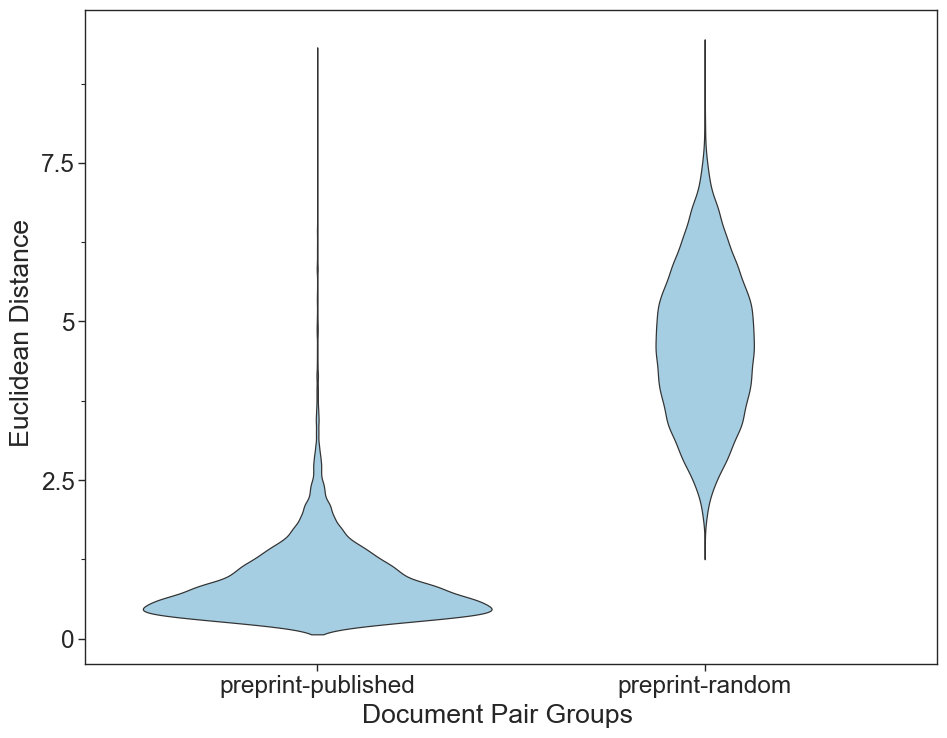

<ggplot: (8748377738844)>


In [32]:
g = (
    p9.ggplot(
        final_original_df.replace(
            {
                "pre_vs_published": "preprint-published",
                "pre_vs_random": "preprint-random",
            }
        )
    )
    + p9.aes(x="label", y="distance")
    + p9.geom_violin(fill="#a6cee3")
    + p9.labs(x="Document Pair Groups", y="Euclidean Distance")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=2)
    + p9.theme(figure_size=(11, 8.5))
)
print(g)

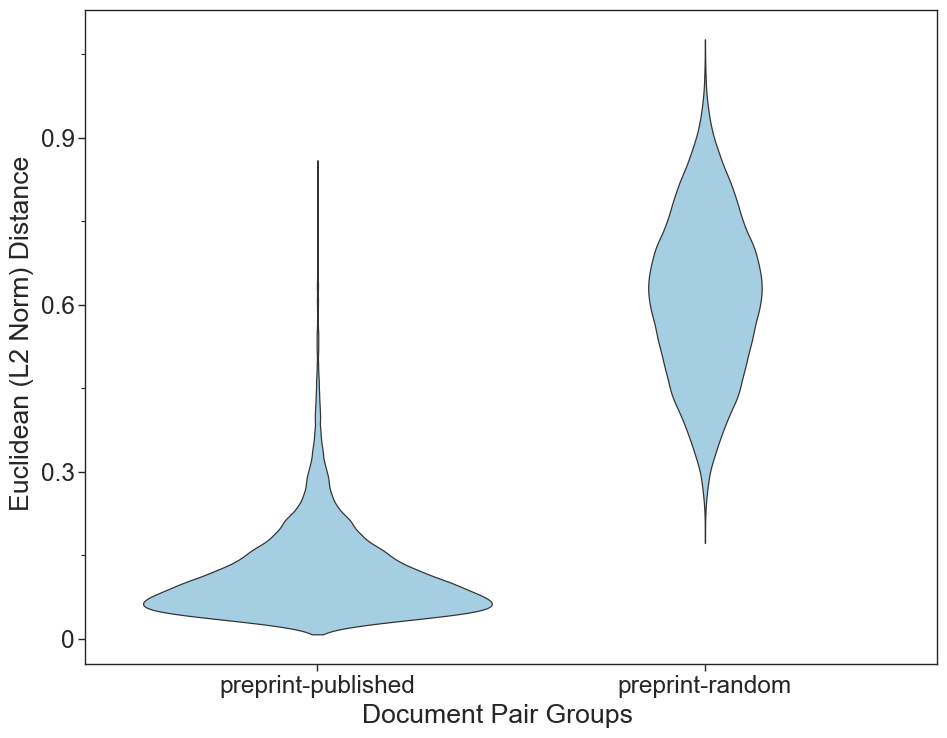

<ggplot: (8747930290822)>


In [33]:
g = (
    p9.ggplot(
        final_cosine_proxy_df.replace(
            {
                "pre_vs_published": "preprint-published",
                "pre_vs_random": "preprint-random",
            }
        )
    )
    + p9.aes(x="label", y="distance")
    + p9.geom_violin(fill="#a6cee3")
    + p9.labs(x="Document Pair Groups", y="Euclidean (L2 Norm) Distance")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=2)
    + p9.theme(figure_size=(11, 8.5))
)
print(g)

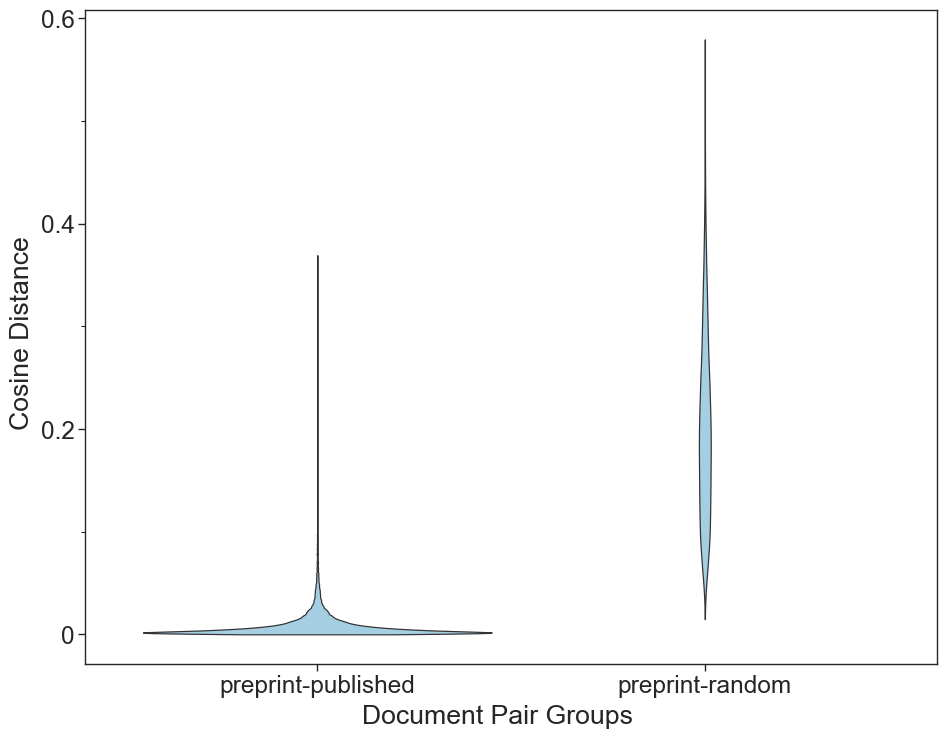

<ggplot: (-9223363288924314459)>


In [34]:
g = (
    p9.ggplot(
        final_cosine_df.replace(
            {
                "pre_vs_published": "preprint-published",
                "pre_vs_random": "preprint-random",
            }
        )
    )
    + p9.aes(x="label", y="distance")
    + p9.geom_violin(fill="#a6cee3")
    + p9.labs(x="Document Pair Groups", y="Cosine Distance")
    + p9.theme_seaborn(context="paper", style="ticks", font="Arial", font_scale=2)
    + p9.theme(figure_size=(11, 8.5))
)
print(g)

# Examine the top N predictions using Recall and Precision

In [35]:
data_rows = []
for df, distance_label in zip(
    [final_original_df, final_cosine_proxy_df, final_cosine_df],
    ["euclidean", "euclidean (L2)", "cosine"],
):
    for k in tqdm.tqdm(range(1, 34503, 200)):
        recall = recall_score(
            df.sort_values("distance").iloc[0:k].label.tolist(),
            ["pre_vs_published"] * k,
            pos_label="pre_vs_published",
        )

        precision = precision_score(
            df.sort_values("distance").iloc[0:k].label.tolist(),
            ["pre_vs_published"] * k,
            pos_label="pre_vs_published",
        )

        data_rows.append(
            {
                "recall": recall,
                "precision": precision,
                "N": k,
                "distance": distance_label,
            }
        )

100%|██████████| 173/173 [00:28<00:00,  6.11it/s]


In [36]:
plot_df = pd.DataFrame.from_records(data_rows)
plot_df.head()

,recall,precision,N,distance
0,1.0,1.0,1,euclidean
1,1.0,1.0,201,euclidean
2,1.0,1.0,401,euclidean
3,1.0,1.0,601,euclidean
4,1.0,1.0,801,euclidean


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/distance_metrics_top_k_recall.png


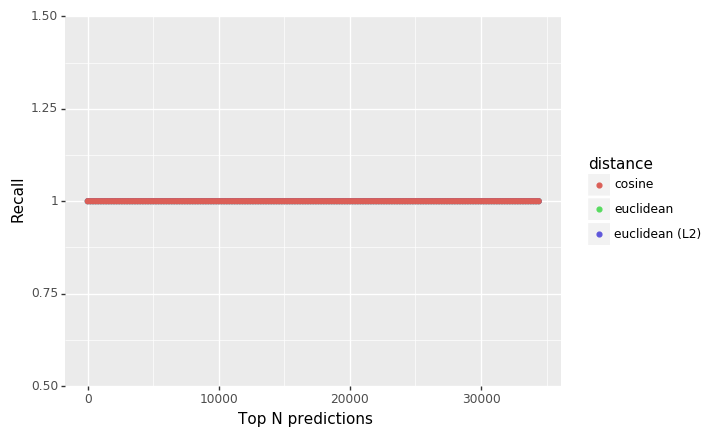

<ggplot: (8748381022931)>


In [37]:
g = (
    p9.ggplot(plot_df, p9.aes(x="N", y="recall", color="distance"))
    + p9.geom_point()
    + p9.labs(x="Top N predictions", y="Recall")
)
g.save("output/figures/distance_metrics_top_k_recall.png", dpi=600)
print(g)

/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/distance_metrics_top_k_precision.png


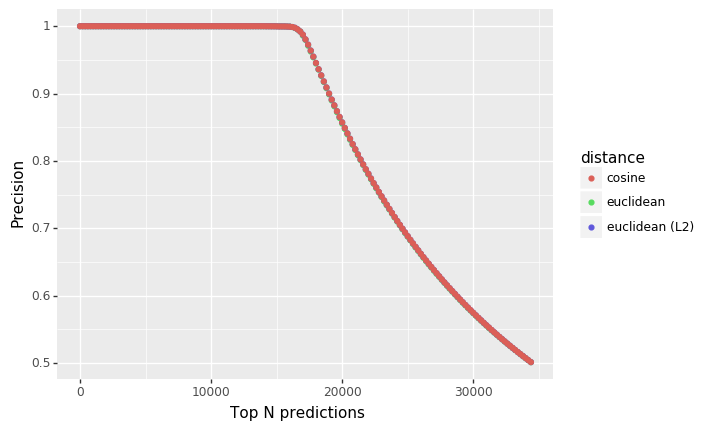

<ggplot: (8747930802303)>


In [38]:
g = (
    p9.ggplot(plot_df, p9.aes(x="N", y="precision", color="distance"))
    + p9.geom_point()
    + p9.labs(x="Top N predictions", y="Precision")
)
g.save("output/figures/distance_metrics_top_k_precision.png", dpi=600)
print(g)

Take Home Points:
1. For this particular task the type of distance metric doesn't matter as performance remains the same.
2. Recall is the same regardless of the prediction label, while looking at precision we notice a change in performance.
3. As we incorporate more predictions precision suffers which makes sense given that the true negatives are going to be incorporated as well.
4. Main argument is distance metric doesn't matter in this case but cosine distance/euclidean normalized distance is superior in general tasks.